# Implementing Decision Trees  

In [1]:
import tools.extract as ex
import numpy as np

iris_data = ex.load_file("data/iris/data.csv")
iris_data[:5]

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Splitting Criterion

1. Misclassification Rate
    - $i_E (t) = 1 -  \max_c p(y=c| t)$
    
    
2. Entropy
    - $i_H (t) = - \sum_{c  \in C} \pi_{c} \log \pi_{c} $
    

3. Gini Index
    - $i_G (t) = \sum_{c  \in C} \pi_{c} (1 - \pi_{c}) = 1 - \sum_{c \in C} \pi_c^2$

    

In [21]:
def get_frequencies(labels):
    from collections import Counter

    cnt = Counter(labels)
    frequencies = np.array(list(cnt.values()))
    
    normalizer = np.sum(frequencies)
    frequencies = frequencies / normalizer
    
    return frequencies

labels = ["a","a","i","i","i"]
frequencies = get_frequencies(labels)
frequencies

array([0.4, 0.6])

In [30]:

def get_misclass(frequencies):
    return 1 - max(frequencies)/sum(frequencies)

def get_entropy(frequencies):
    return -1 * ( frequencies.T @ np.log2(frequencies) )

def get_gini(frequencies):
    return 1 - frequencies.T @ frequencies

def get_impurity(freq, criterion="gini"):
    measure_impurity = {
        "gini":     get_gini(freq),
        "entropy":  get_entropy(freq),
        "misclass": get_misclass(freq)
    }
    return measure_impurity[criterion]


print( f"i_E = {get_misclass(frequencies)}")
print( f"i_H = {get_entropy(frequencies)}")
print( f"i_G = {get_gini(frequencies)}")
print( f"i_G = {get_impurity(frequencies, 'gini')}")
    
#def get_impurity()

i_E = 0.4
i_H = 0.9709505944546686
i_G = 0.48
i_G = 0.48


### Let's compare these criteria for binary classification!

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  


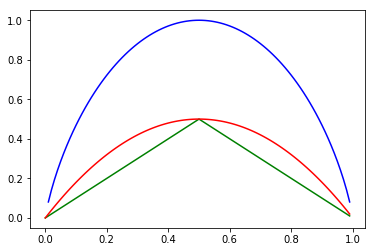

In [31]:
import matplotlib.pyplot as plt 

crit_p     = np.arange(0,1,0.01)

vector_p     = crit_p.reshape((-1, 1))
vector_not_p = 1 - vector_p

frequencies = np.hstack((vector_p, vector_not_p))

crit_E = np.apply_along_axis(get_misclass, 1, frequencies)
crit_H = np.apply_along_axis(get_entropy, 1, frequencies)
crit_G = np.apply_along_axis(get_gini, 1, frequencies)

plt.plot(crit_p, crit_E,'g-')
plt.plot(crit_p, crit_G,'r-')
plt.plot(crit_p, crit_H,'b-')
plt.show()

### Let's see how this works for Multiclass Classification (3-classes)

Text(0.5, 0, 'p2')

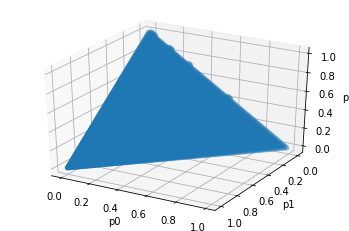

In [7]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as Axes3D

prob = []
for p0 in np.arange(0, 1, 0.01):
    for p1 in np.arange(0, 1 - p0, 0.01):
        prob.append( [p0, p1, 1-p0-p1] )

prob = np.array(prob)

fig = plt.figure()
ax  = fig.add_subplot(111,projection="3d")

ax.scatter( prob[:,1], prob[:,2], prob[:,0] )

ax.invert_yaxis()

ax.set_xlabel('p0')
ax.set_ylabel('p1')
ax.set_zlabel('p2')

In [8]:
def plot_sideview(p1=0):
    snapshot = prob [prob[:,1] == p1]
    plt.ylim([0,1])
    plt.xlim([0,1])
    plt.xlabel("p0")
    plt.ylabel("p2")
    plt.title(f"Possible probability combinations given p1 = {p1}")
    plt.plot(snapshot[:,0], snapshot[:,2])
    plt.show()

In [9]:
import ipywidgets
from ipywidgets import interactive

iplot = interactive(lambda step: plot_sideview(step/100), 
                    step=ipywidgets.IntSlider(
                        min=0, max=100, step=1, value=1, continuous_update=True
                    ))
iplot

interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

In [147]:
class DtNode:
    def __init__(self, X, y, depth=None, criterion="gini"):
        self.split_val = None
        self.depth = depth
        self.X = X
        self.y = y
        self.criterion = "gini"
        
        frequencies = get_frequencies(self.y)
        self.node_impurity = get_impurity(frequencies, criterion=self.criterion)
    
    def get_improvements(self, feature):
        improvements = []
        
        possible_split_values = list( set( self.X[feature] ))
        
        for value in sorted(possible_split_values):
            
            true_labels  = self.y[ self.X[feature] <= value ]
            false_labels = self.y[ self.X[feature] > value ]
            
            if len(true_labels) != 0 and len(false_labels) != 0:
                true_freq  = get_frequencies(true_labels)
                false_freq = get_frequencies(false_labels)
            
                total = len(self.X)
            
                expected_impurity  = get_misclass(true_freq)  * (len(true_labels)/total)
                expected_impurity += get_misclass(false_freq) * (len(false_labels)/total)
            
                improvements.append((value, self.node_impurity - expected_impurity))
            else:
                improvements.append(( value, 0))
            
        return improvements
        
    def fit( self):
        best_improvement = None
        best_feature = ""
        
        for feature in self.X.columns:
            imp = max( self.get_improvements(feature), key=lambda x: x[1])
            
            if best_improvement is None or best_improvement[1] < imp[1]:
                best_improvement = imp
                best_feature = feature
        
        if best_improvement[1] <= 0:
            return
        
        self.split_improvement = best_improvement[1]
        
        self.split(feature, best_improvement[0])
        
    def split(self, feature, value):
        
        if self.depth == 0:
            return
        
        self.split_value = value
        self.split_feature = feature
        
        true_idx  = self.X[feature] <= value
        false_idx = true_idx != True
        
        true_X  = self.X[ true_idx ]
        true_y  = self.y[ true_idx ]
        false_X = self.X[ false_idx ]
        false_y = self.y[ false_idx ]
        
        if(self.depth is None):
            self.true_node  = DtNode(true_X,  true_y,  None)
            self.false_node = DtNode(false_X, false_y, None )
        else:
            self.true_node  = DtNode(true_X,  true_y,  self.depth - 1)
            self.false_node = DtNode(false_X, false_y, self.depth - 1)
        

In [148]:
node = DtNode(iris_data.iloc[:,:4], iris_data['class'], 1)
max(node.get_improvements('sepal-length'), key=lambda x: x[1])

(5.7, 0.30666666666666675)

In [149]:
#imps = (node.get_improvements('sepal-length'))
node.fit()

In [146]:
print(node.split_feature)
print(node.split_value)
print(node.split_value)

petal-width
1.9


In [77]:
node.X.columns

Index(['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class'], dtype='object')

In [28]:
iris_data["sepal-length"] >= 5

0       True
1      False
2      False
3      False
4       True
5       True
6      False
7       True
8      False
9      False
10      True
11     False
12     False
13     False
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22     False
23      True
24     False
25      True
26      True
27      True
28      True
29     False
       ...  
120     True
121     True
122     True
123     True
124     True
125     True
126     True
127     True
128     True
129     True
130     True
131     True
132     True
133     True
134     True
135     True
136     True
137     True
138     True
139     True
140     True
141     True
142     True
143     True
144     True
145     True
146     True
147     True
148     True
149     True
Name: sepal-length, Length: 150, dtype: bool